# Define configurations

In [1]:
user = 'participant2'
frequency = '15min' # 15min | 15s
dataset_type = '' # ''

if frequency == '15min':
    record_size_per_day = 96
elif frequency == '15s':
    record_size_per_day = 5760

# Columns to include    
if dataset_type == '':
    columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
            'time_from_last_drug_taken', 'wearing_off' ]

metrics = {
    'balanced_accuracy': 'Bal. Acc.',
    'f1_score': 'F1 Score',
    'accuracy': 'Acc.',
    'precision': 'Precision',
    'sensitivity': 'Recall / Sn',
    'specificity': 'Sp',
    'auc': 'AUC'
}

# Preparation

## Load libraries

In [2]:
from datetime import datetime
from datetime import timedelta
from typing import Union, Generator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

import sklearn
from photonai.base import Hyperpipe, PipelineElement, Stack, Switch
from photonai.optimization import FloatRange, IntegerRange, Categorical, BooleanSwitch, PhotonHyperparam
from photonai.optimization import Categorical as PhotonCategorical
from photonai.optimization import MinimumPerformanceConstraint, DummyPerformanceConstraint, BestPerformanceConstraint
from photonai.optimization.base_optimizer import PhotonSlaveOptimizer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from skopt import Optimizer
from skopt.space import Real, Integer, Dimension
from skopt.space import Categorical as skoptCategorical
from photonai.photonlogger.logger import logger
from photonai.optimization.scikit_optimize.sk_opt import SkOptOptimizer

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning)
from photonai.base import Hyperpipe
from photonai.optimization import MinimumPerformanceConstraint
from photonai.photonlogger import logger 
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Load combined data

In [3]:
combined_data = pd.read_excel(f'./data/combined_data/{dataset_type}combined_data_{user}_{frequency}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
if dataset_type == '':
    # Define prediction horizon
    predict_ahead = pd.Timedelta(minutes=60)  # <- change to 2 or pd.Timedelta(seconds=15) as needed

    # Ensure datetime index
    combined_data = combined_data.sort_index()
    combined_data.index = pd.to_datetime(combined_data.index)

    # Estimate time delta between rows (assumes regular sampling)
    median_step = combined_data.index.to_series().diff().median()

    # How many steps to shift based on prediction horizon
    steps_ahead = int(predict_ahead / median_step)

    # Shift labels backward to align X at time t with y at t + n
    combined_data['wearing_off_future'] = combined_data['wearing_off'].shift(-steps_ahead)

    # Drop rows with NaNs from shifting
    combined_data = combined_data.dropna(subset=['wearing_off_future'])

    # Define X and y (keep X as DataFrame for .iloc to work)
    X = combined_data.loc[:, columns[1:-1]]  # or X = combined_data[feature_cols]
    y = combined_data['wearing_off_future'].astype(int).values


## Define Functions

In [4]:
# Show feature importances
def print_feature_importances(pipeline):
    output = ''
    if pipeline.optimum_pipe.feature_importances_ is None:
        output = 'Best Hyperparameter Configuration is a non-linear SVM, thus feature importances cannot be retrieved'
    else:
        output = 'Feature Importances using the Best Hyperparameter Config'
        if not [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE']:
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
        else:
            mask = [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE'][0]
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])[mask]
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
    return output

In [5]:
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


In [6]:
def plot_confusion_matrix_from_pipeline(pipeline):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(
        pipeline.results_handler.get_test_predictions()['y_true'],
        pipeline.results_handler.get_test_predictions()['y_pred'],
        labels=[0,1], normalize=None)
    ax = plt.subplot()
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'25'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    # title_font = {'size':'21'}  # Adjust to fit
    # ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=25)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Good', 'Wearing-Off']);
    ax.yaxis.set_ticklabels(['Good', 'Wearing-Off']);
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    # plt.savefig('./participant2-downsampling-confusionmatrix-real.pdf', bbox_inches='tight')
    plt.show()

In [7]:
# Write other reports to summary file
def add_other_report_to_summary(pipeline, with_estimator_comparison=True):
    with open(f'{pipeline.output_settings.results_folder}/photon_summary.txt', "a+") as summary_file:
        # 1. Write comparison of learning algorithms
        if with_estimator_comparison:
            summary_file.write("\n\n")
            summary_file.write("Comparison on learning algorithms on validation set")
            summary_file.write("\n")
            summary_file.write(str(pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator()))

        # 2. Write feature importance
        summary_file.write("\n\n")
        summary_file.write("Feature Importance")
        summary_file.write(print_feature_importances(pipeline))
        
        # 3. Write beautified average test performance across outer folds
        # a. Get Average Test Performance Across Outer Folds
        test_metric_result = pipeline.results.get_test_metric_dict()
        
        # b. Replace display metric name
        #   Reference: https://stackoverflow.com/a/55250496/2303766
        test_metric_result = { metrics[metric]: test_metric_result[metric]
                                  for metric, metric_name in metrics.items() if metric in test_metric_result
                             }
        
        # c. Add beautified average test performance across outer folds to file 
        summary_file.write("\n\n")
        summary_file.write("Average Test Performance Across Outer Folds")
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(
                    test_metric_result
                ).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )
        
        # 4. Write outer fold results
        summary_file.write("\n\n")
        summary_file.write("Outer Fold Best Estimators' Performance")
        summary_file.write("\n")
        handler = pipeline.results_handler
        performance_table = handler.get_performance_table()
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold', 'best_config', 'n_train', 'n_validation']].transpose(),
                    tablefmt='psql', headers='keys'
                )
            )
            summary_file.write("\n")
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold'] + list(metrics.keys())].round(4).transpose(),
                    tablefmt='psql', floatfmt=".4f", headers='keys'
                )
            )
            
        outer_fold_performance = {}
        config_evals = handler.get_config_evaluations()
        for metric in metrics.keys():
            # print(f'{metric}')
            for i, j in enumerate(config_evals[metric]):
                if f'{metric}_mean' in outer_fold_performance:
                    # outer_fold_performance[f'{metric}_max'].append(np.max(j))
                    outer_fold_performance[f'{metric}_mean'].append(np.mean(j))
                    outer_fold_performance[f'{metric}_std'].append(np.std(j))
                else:
                    # outer_fold_performance[f'{metric}_max'] = [np.max(j)]
                    outer_fold_performance[f'{metric}_mean'] = [np.mean(j)]
                    outer_fold_performance[f'{metric}_std'] = [np.std(j)]
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(outer_fold_performance).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )

In [8]:
# PhotonAI Optimize Monkey-patch
#     Added random_state for Optimize for result replicability
def prepare(self, pipeline_elements: list, maximize_metric: bool) -> None:
    """
    Initializes hyperparameter search with scikit-optimize.

    Assembles all hyperparameters of the list of PipelineElements
    in order to prepare the hyperparameter space.
    Hyperparameters can be accessed via pipe_element.hyperparameters.

    Parameters:
        pipeline_elements:
            List of all PipelineElements to create the hyperparameter space.

        maximize_metric:
            Boolean to distinguish between score and error.

    """
    self.start_time = None
    self.optimizer = None
    self.hyperparameter_list = []
    self.maximize_metric = maximize_metric

    # build skopt space
    space = []
    for pipe_element in pipeline_elements:
        if pipe_element.__class__.__name__ == 'Switch':
            error_msg = 'Scikit-Optimize cannot operate in the specified hyperparameter space with a Switch ' \
                        'element. We recommend the use of SMAC.'
            logger.error(error_msg)
            raise ValueError(error_msg)

        if hasattr(pipe_element, 'hyperparameters'):
            for name, value in pipe_element.hyperparameters.items():
                # if we only have one value we do not need to optimize
                if isinstance(value, list) and len(value) < 2:
                    self.constant_dictionary[name] = value[0]
                    continue
                if isinstance(value, PhotonCategorical) and len(value.values) < 2:
                    self.constant_dictionary[name] = value.values[0]
                    continue
                skopt_param = self._convert_photonai_to_skopt_space(value, name)
                if skopt_param is not None:
                    space.append(skopt_param)

    if self.constant_dictionary:
        msg = "PHOTONAI has detected some one-valued params in your hyperparameters. Pleas use the kwargs for " \
              "constant values. This run ignores following settings: " + str(self.constant_dictionary.keys())
        logger.warning(msg)
        warnings.warn(msg)

    if len(space) == 0:
        msg = "Did not find any hyperparameter to convert into skopt space."
        logger.warning(msg)
        warnings.warn(msg)
    else:
        self.optimizer = Optimizer(space,
                                   base_estimator=self.base_estimator,
                                   n_initial_points=self.n_initial_points,
                                   initial_point_generator=self.initial_point_generator,
                                   acq_func=self.acq_func,
                                   acq_func_kwargs=self.acq_func_kwargs,
                                   random_state=4
                                  )
    self.ask = self.ask_generator()
    
#    Monkey patched new prepare function
SkOptOptimizer.prepare = prepare

## Visualize Data Split

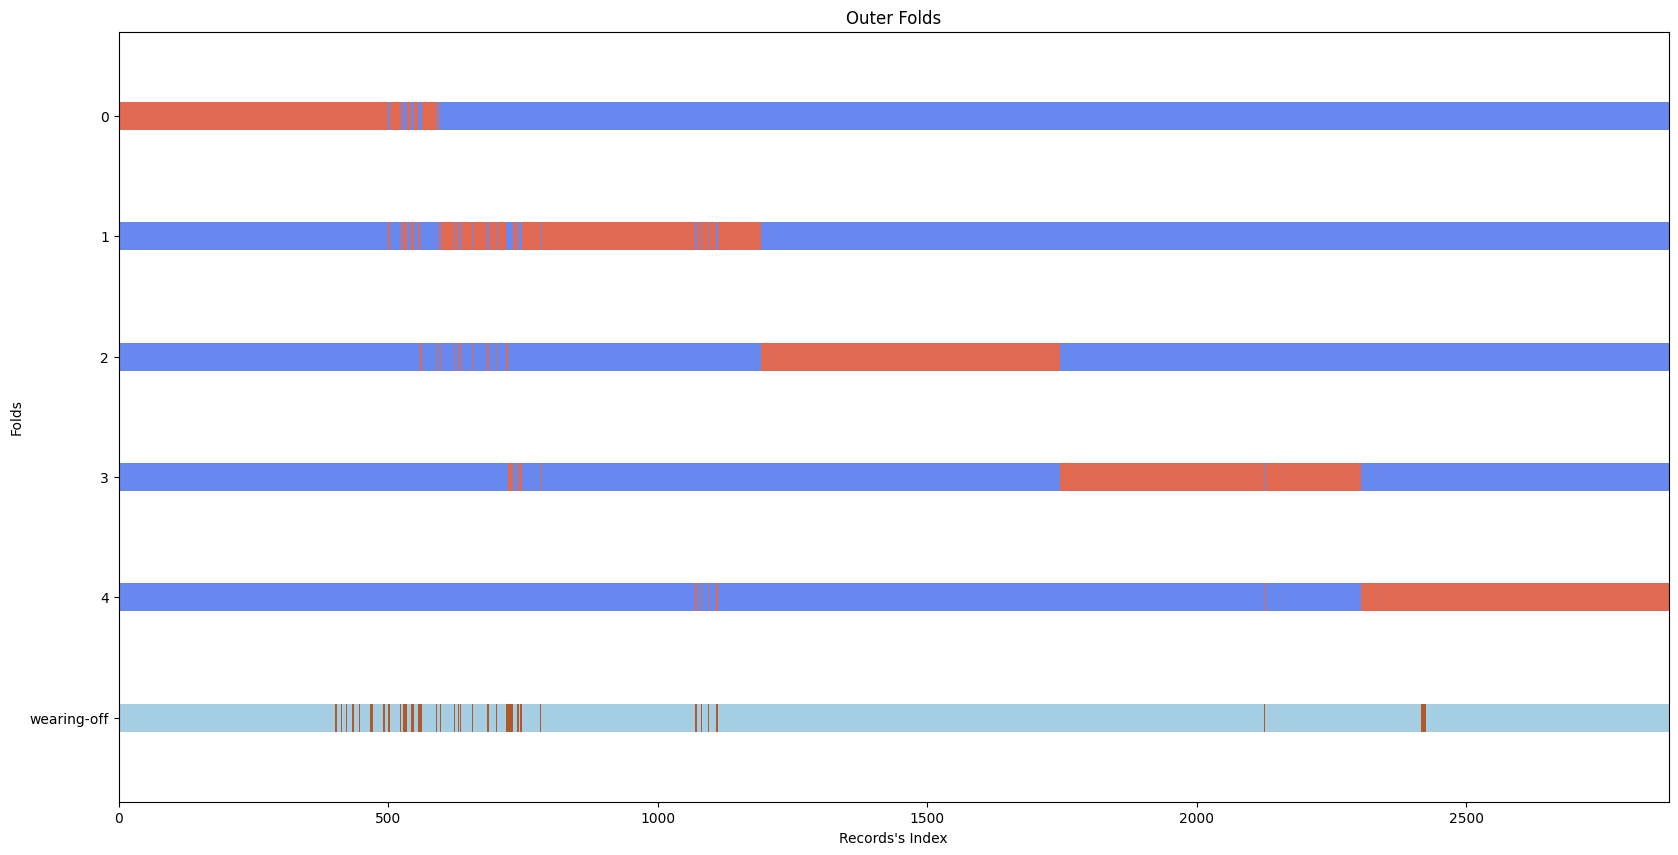

Train Set for Outer Fold 0
[ 508  509  510 ... 2873 2874 2875]

Train Set for Outer Fold 1
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 2
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 3
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 4
[   0    1    2 ... 2310 2311 2312]



In [9]:
# Outer CV
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=5, shuffle=False)
plot_cv_indices(cv, X, y, ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title('Outer Folds')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

training_folds = []
for train, test in cv.split(X, y):
    print(f'Train Set for Outer Fold {len(training_folds)}')
    print(train)
    training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

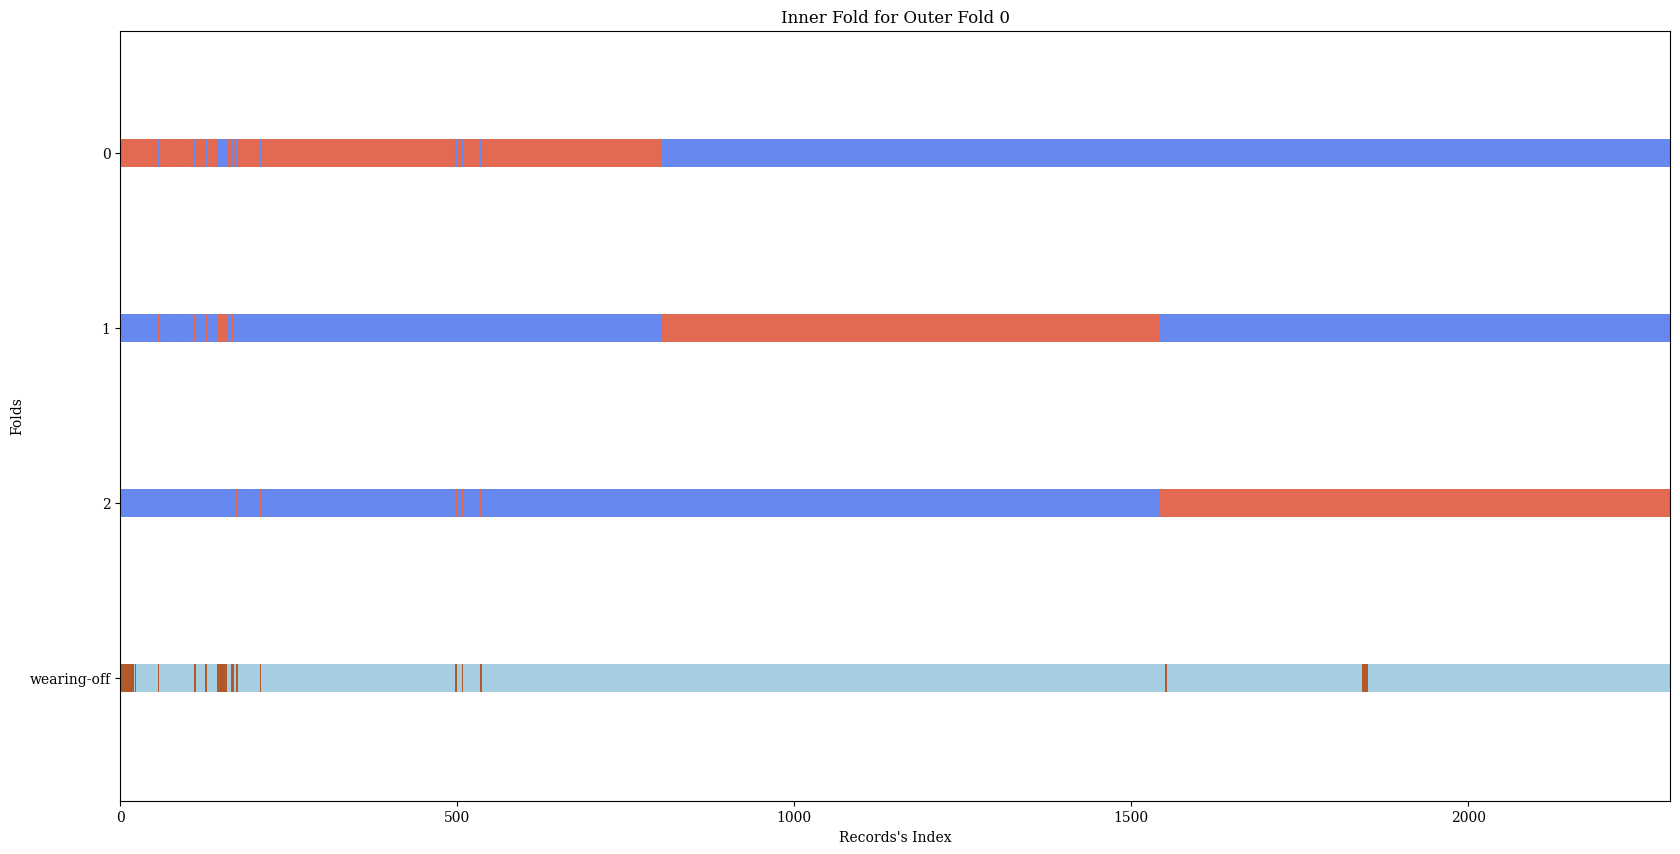

Train Sets for Outer Fold 0
Train Set for Inner Fold 0
[  54   62   66 ... 2297 2298 2299]

Train Set for Inner Fold 1
[   0    1    2 ... 2297 2298 2299]

Train Set for Inner Fold 2
[   0    1    2 ... 1546 1547 1548]



In [10]:
# Inner CV
outer_fold_number = 0

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=3, shuffle=False)
plot_cv_indices(cv, X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]], ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title(f'Inner Fold for Outer Fold {outer_fold_number}')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

inner_training_folds = []
print(f'Train Sets for Outer Fold {outer_fold_number}')
for train, test in cv.split(X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]]):
    print(f'Train Set for Inner Fold {len(inner_training_folds)}')
    print(train)
    inner_training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

# Pipeline

## Define learning algorithms

In [11]:
from photonai import PipelineElement, Switch
from photonai.optimization import IntegerRange, FloatRange
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

estimator_selection = Switch('estimators')

estimator_selection += PipelineElement(
    "LogisticRegression",
    base_element=LogisticRegression(class_weight='balanced', random_state=4),
    hyperparameters={
        'C': FloatRange(1, 10)
    }
)

estimator_selection += PipelineElement(
    "DecisionTreeClassifier",
    base_element=DecisionTreeClassifier(random_state=4, criterion='gini'),
    hyperparameters={
        'min_samples_split': IntegerRange(2, 30),
        'min_samples_leaf': IntegerRange(2, 30)
    }
)

estimator_selection += PipelineElement(
    "LinearSVC",
    base_element=LinearSVC(class_weight='balanced', random_state=4),
    hyperparameters={
        'C': FloatRange(1, 25)
    }
)

estimator_selection += PipelineElement(
    "RandomForestClassifier",
    base_element=RandomForestClassifier(random_state=4, criterion='gini', bootstrap=True),
    hyperparameters={
        'min_samples_split': IntegerRange(2, 30),
        'max_features': ['sqrt', 'log2']
    }
)

estimator_selection += PipelineElement(
    "GradientBoostingClassifier",
    base_element=GradientBoostingClassifier(random_state=4),
    hyperparameters={
        'loss': ['log_loss', 'exponential'],
        'learning_rate': FloatRange(0.001, 1, 'logspace')
    }
)

# Add LGBMClassifier
estimator_selection += PipelineElement(
    "LGBMClassifier",
    base_element=LGBMClassifier(random_state=4),
    hyperparameters={
        "n_estimators": IntegerRange(50, 150, step=10, range_type="range"),
        "learning_rate": FloatRange(0.01, 0.3, range_type="logspace"),
        "max_depth": IntegerRange(3, 10, step=1, range_type="range")
    }
)
# estimator_selection += PipelineElement(
#     "LGBMClassifier",
#     base_element=LGBMClassifier(random_state=4),
#     hyperparameters={
#         "n_estimators": IntegerRange(50, 150, step=10, range_type="range"),
#         "learning_rate": FloatRange(0.01, 0.3, range_type="logspace"),
#         "max_depth": IntegerRange(3, 10, step=1, range_type="range")
#     }
# )

## Initial Pipeline

In [12]:
# initial_pipeline = Hyperpipe('1 - Initial Pipeline',
#                      outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
#                      inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
#                      use_test_set = False,
#                      metrics = list(metrics.keys()),
#                      best_config_metric='balanced_accuracy',
#                      optimizer='switch',
#                      optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
#                      project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
#                      cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
#                      verbosity=1,
#                      performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# # Add learning algorithms to compare
# initial_pipeline += estimator_selection

# # Fit hyperpipe
# initial_pipeline.fit(X, y)

# # Show learning algorithms mean validation results
# # print("Comparison on learning algorithms on validation set")
# # print(initial_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # # Show feature importances
# # print_feature_importances(initial_pipeline)

# # # View CV splits for debugging
# # for k,v in initial_pipeline.cross_validation.outer_folds.items():
# #     print(v.train_indices)
# #     print(v.test_indices)
# #     print(len(v.train_indices), len(v.test_indices))
# #     print()

# # Write other reports to summary file
# add_other_report_to_summary(initial_pipeline)

## Feature Selection Pipeline

In [13]:
# classifier = LogisticRegression(random_state=4).fit(X, y)

# feature_selection_pipeline = Hyperpipe('2 - Feature Selection Pipline',
#                      outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
#                      inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
#                      use_test_set = False,
#                      metrics = list(metrics.keys()),
#                      best_config_metric='balanced_accuracy',
#                      optimizer='switch',
#                      optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
#                      project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
#                      cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
#                      verbosity=1,
#                      performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# feature_selection_pipeline += PipelineElement('RFE', 
#                            hyperparameters={
#                                'n_features_to_select': IntegerRange(2, (len(columns) - 2))
#                            }, estimator=classifier)

# feature_selection_pipeline += estimator_selection

# # Fit hyperpipe
# feature_selection_pipeline.fit(X, y)

# # Show learning algorithms mean validation results
# # print("Comparison on learning algorithms on validation set")
# # print(feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # # Show feature importances
# # print_feature_importances(feature_selection_pipeline)

# # # View CV splits for debugging
# # for k,v in feature_selection_pipeline.cross_validation.outer_folds.items():
# #     print(v.train_indices)
# #     print(v.test_indices)
# #     print(len(v.train_indices), len(v.test_indices))
# #     print()

# # Write other reports to summary file
# add_other_report_to_summary(feature_selection_pipeline)

## Class Imbalanced Pipeline

In [14]:
# class_imbalanced_pipeline = Hyperpipe('3 - Class Imbalanced Pipline',
#                      outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
#                      inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
#                      use_test_set = False,
#                      metrics = list(metrics.keys()),
#                      best_config_metric='balanced_accuracy',
#                      optimizer='switch',
#                      optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
#                      project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
#                      cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
#                      verbosity=1,
#                      performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
# class_imbalanced_pipeline += PipelineElement('ImbalancedDataTransformer',
#                            hyperparameters={ 'method_name': tested_methods })

# class_imbalanced_pipeline += estimator_selection

# # Fit hyperpipe
# class_imbalanced_pipeline.fit(X, y)

# # Show learning algorithms mean validation results
# # print("Comparison on learning algorithms on validation set")
# # print(class_imbalanced_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # # Show feature importances
# # print_feature_importances(class_imbalanced_pipeline)

# # # View CV splits for debugging
# # for k,v in class_imbalanced_pipeline.cross_validation.outer_folds.items():
# #     print(v.train_indices)
# #     print(v.test_indices)
# #     print(len(v.train_indices), len(v.test_indices))
# #     print()

# # Write other reports to summary file
# add_other_report_to_summary(class_imbalanced_pipeline)

In [15]:
import time
import os
from photonai.base.hyperpipe import OutputSettings

# Save original method
original_update_settings = OutputSettings.update_settings

def patched_update_settings(self, name, timestamp):
    max_retries = 5
    delay = 1  # seconds
    
    for attempt in range(max_retries):
        try:
            original_update_settings(self, name, timestamp)
            break  # success, exit retry loop
        except PermissionError as e:
            print(f"PermissionError on attempt {attempt+1}/{max_retries} when updating settings: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                print("Max retries reached. Raising the PermissionError.")
                raise

# Apply monkey patch
OutputSettings.update_settings = patched_update_settings


## Class Imbalanced + Feature Selection Pipeline

In [16]:
# classifier = LogisticRegression(random_state=4).fit(X, y)

# class_imbalanced_feature_selection_pipeline = Hyperpipe('4 - CI and FS Pipeline',
#                      outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
#                      inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
#                      use_test_set = False,
#                      metrics = list(metrics.keys()),
#                      best_config_metric='balanced_accuracy',
#                      optimizer='switch',
#                      optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
#                      project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
#                      cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
#                      verbosity=1,
#                      performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])


# tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
# class_imbalanced_feature_selection_pipeline += PipelineElement('ImbalancedDataTransformer',
#                            hyperparameters={ 'method_name': tested_methods })

# class_imbalanced_feature_selection_pipeline += PipelineElement('RFE', 
#                            hyperparameters={
#                                'n_features_to_select': IntegerRange(2, (len(columns) - 2))
#                            }, estimator=classifier)

# class_imbalanced_feature_selection_pipeline += estimator_selection

# # Fit hyperpipe
# class_imbalanced_feature_selection_pipeline.fit(X, y)

# # Show learning algorithms mean validation results

# # print("Comparison on learning algorithms on validation set")
# # print(class_imbalanced_feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # # Show feature importances
# # print_feature_importances(class_imbalanced_feature_selection_pipeline)

# # # View CV splits for debugging
# # for k,v in class_imbalanced_feature_selection_pipeline.cross_validation.outer_folds.items():
# #     print(v.train_indices)
# #     print(v.test_indices)
# #     print(len(v.train_indices), len(v.test_indices))
# #     print()

# # Write other reports to summary file
# add_other_report_to_summary(class_imbalanced_feature_selection_pipeline)

## Final Pipeline

### CI GB

25/06/2025-15:07:57 | Output Folder: ./analysis/participant2_15min\5FinalPipelineCIFSGB_results_2025-06-25_15-07-57
PHOTONAI ANALYSIS: 5FinalPipelineCIFSGB
25/06/2025-15:07:57 | Preparing data and PHOTONAI objects for analysis...
25/06/2025-15:07:57 | Checking input data...
25/06/2025-15:07:57 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.55771905424201% belongs to 0
25/06/2025-15:07:57 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
25/06/2025-15:07:57 | Preparing data for outer fold 1...
25/06/2025-15:07:57 | Preparing Hyperparameter Optimization...
25/06/2025-15:07:57 | Running Dummy Estimator...
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
| balanced_accuracy | 0.5000 |


Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:07:59 | Computed configuration 2/30 in 0:00:01.687261
25/06/2025-15:07:59 | Performance:             balanced_accuracy - Train: 0.9450, Validation: 0.5743
25/06/2025-15:07:59 | Best Performance So Far: balanced_accuracy - Train: 0.9450, Validation: 0.5743
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
25/06/2025-15:07:59 | Computed configuration 3/30 in 0:00:00.298556
25/06/2025-15:07:59 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5045
25/06/2025-15:07:59 | Best Performance So Far: balanced_accuracy - Train: 0.9450, Validation: 0.5743
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=devi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:08:00 | Computed configuration 5/30 in 0:00:01.103363
25/06/2025-15:08:00 | Performance:             balanced_accuracy - Train: 0.9674, Validation: 0.5350
25/06/2025-15:08:00 | Best Performance So Far: balanced_accuracy - Train: 0.9450, Validation: 0.5743
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
25/06/2025-15:08:02 | Computed configuration 6/30 in 0:00:01.959597
25/06/2025-15:08:02 | Performance:             balanced_accuracy - Train: 0.9498, Validation: 0.5472
25/06/2025-15:08:02 | Best Performance So Far: balanced_accuracy - Train: 0.9450, Validation: 0.5743
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=expon

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:08:06 | Computed configuration 10/30 in 0:00:01.947520
25/06/2025-15:08:06 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.3384
25/06/2025-15:08:06 | Best Performance So Far: balanced_accuracy - Train: 0.9450, Validation: 0.5743
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
25/06/2025-15:08:07 | Computed configuration 11/30 in 0:00:01.038616
25/06/2025-15:08:07 | Performance:             balanced_accuracy - Train: 0.9369, Validation: 0.5418
25/06/2025-15:08:07 | Best Performance So Far: balanced_accuracy - Train: 0.9450, Validation: 0.5743
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=e

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:08:44 | Computed configuration 2/30 in 0:00:01.901395
25/06/2025-15:08:44 | Performance:             balanced_accuracy - Train: 0.9209, Validation: 0.6973
25/06/2025-15:08:44 | Best Performance So Far: balanced_accuracy - Train: 0.9209, Validation: 0.6973
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
25/06/2025-15:08:45 | Computed configuration 3/30 in 0:00:00.347674
25/06/2025-15:08:45 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6075
25/06/2025-15:08:45 | Best Performance So Far: balanced_accuracy - Train: 0.9209, Validation: 0.6973
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=devi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:08:46 | Computed configuration 5/30 in 0:00:01.116013
25/06/2025-15:08:46 | Performance:             balanced_accuracy - Train: 0.9370, Validation: 0.6386
25/06/2025-15:08:46 | Best Performance So Far: balanced_accuracy - Train: 0.9209, Validation: 0.6973
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
25/06/2025-15:08:48 | Computed configuration 6/30 in 0:00:01.967877
25/06/2025-15:08:48 | Performance:             balanced_accuracy - Train: 0.9306, Validation: 0.7178
25/06/2025-15:08:48 | Best Performance So Far: balanced_accuracy - Train: 0.9306, Validation: 0.7178
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=expon

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:08:52 | Computed configuration 10/30 in 0:00:01.946692
25/06/2025-15:08:52 | Performance:             balanced_accuracy - Train: 0.9992, Validation: 0.6220
25/06/2025-15:08:52 | Best Performance So Far: balanced_accuracy - Train: 0.9306, Validation: 0.7178
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
25/06/2025-15:08:54 | Computed configuration 11/30 in 0:00:01.102666
25/06/2025-15:08:54 | Performance:             balanced_accuracy - Train: 0.8981, Validation: 0.6615
25/06/2025-15:08:54 | Best Performance So Far: balanced_accuracy - Train: 0.9306, Validation: 0.7178
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=e

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:09:40 | Computed configuration 2/30 in 0:00:01.800744
25/06/2025-15:09:40 | Performance:             balanced_accuracy - Train: 0.8907, Validation: 0.5301
25/06/2025-15:09:40 | Best Performance So Far: balanced_accuracy - Train: 0.8907, Validation: 0.5301
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
25/06/2025-15:09:40 | Computed configuration 3/30 in 0:00:00.341283
25/06/2025-15:09:40 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5116
25/06/2025-15:09:40 | Best Performance So Far: balanced_accuracy - Train: 0.8907, Validation: 0.5301
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=devi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:09:42 | Computed configuration 5/30 in 0:00:01.050560
25/06/2025-15:09:42 | Performance:             balanced_accuracy - Train: 0.9298, Validation: 0.4927
25/06/2025-15:09:42 | Best Performance So Far: balanced_accuracy - Train: 0.8907, Validation: 0.5301
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
25/06/2025-15:09:43 | Computed configuration 6/30 in 0:00:01.893741
25/06/2025-15:09:43 | Performance:             balanced_accuracy - Train: 0.9237, Validation: 0.5058
25/06/2025-15:09:43 | Best Performance So Far: balanced_accuracy - Train: 0.8907, Validation: 0.5301
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=expon

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:09:48 | Computed configuration 10/30 in 0:00:01.973969
25/06/2025-15:09:48 | Performance:             balanced_accuracy - Train: 0.9990, Validation: 0.4921
25/06/2025-15:09:48 | Best Performance So Far: balanced_accuracy - Train: 0.8907, Validation: 0.5301
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
25/06/2025-15:09:49 | Computed configuration 11/30 in 0:00:01.065197
25/06/2025-15:09:49 | Performance:             balanced_accuracy - Train: 0.8902, Validation: 0.5484
25/06/2025-15:09:49 | Best Performance So Far: balanced_accuracy - Train: 0.8902, Validation: 0.5484
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=e

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:10:21 | Computed configuration 2/30 in 0:00:02.001086
25/06/2025-15:10:21 | Performance:             balanced_accuracy - Train: 0.8900, Validation: 0.4880
25/06/2025-15:10:21 | Best Performance So Far: balanced_accuracy - Train: 0.8900, Validation: 0.4880
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
25/06/2025-15:10:21 | Computed configuration 3/30 in 0:00:00.443929
25/06/2025-15:10:21 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4975
25/06/2025-15:10:21 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.4975
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=devi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:10:23 | Computed configuration 5/30 in 0:00:01.353079
25/06/2025-15:10:23 | Performance:             balanced_accuracy - Train: 0.9379, Validation: 0.4514
25/06/2025-15:10:23 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.4975
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
25/06/2025-15:10:25 | Computed configuration 6/30 in 0:00:01.964153
25/06/2025-15:10:25 | Performance:             balanced_accuracy - Train: 0.9214, Validation: 0.4552
25/06/2025-15:10:25 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.4975
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=expon

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:10:29 | Computed configuration 10/30 in 0:00:02.090314
25/06/2025-15:10:29 | Performance:             balanced_accuracy - Train: 0.9974, Validation: 0.5036
25/06/2025-15:10:29 | Best Performance So Far: balanced_accuracy - Train: 0.9974, Validation: 0.5036
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
25/06/2025-15:10:30 | Computed configuration 11/30 in 0:00:00.421494
25/06/2025-15:10:30 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4796
25/06/2025-15:10:30 | Best Performance So Far: balanced_accuracy - Train: 0.9974, Validation: 0.5036
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=ex

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:11:06 | Computed configuration 2/30 in 0:00:01.659231
25/06/2025-15:11:06 | Performance:             balanced_accuracy - Train: 0.9441, Validation: 0.6488
25/06/2025-15:11:06 | Best Performance So Far: balanced_accuracy - Train: 0.9441, Validation: 0.6488
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
25/06/2025-15:11:07 | Computed configuration 3/30 in 0:00:00.309069
25/06/2025-15:11:07 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5456
25/06/2025-15:11:07 | Best Performance So Far: balanced_accuracy - Train: 0.9441, Validation: 0.6488
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=devi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:11:08 | Computed configuration 5/30 in 0:00:01.020778
25/06/2025-15:11:08 | Performance:             balanced_accuracy - Train: 0.9522, Validation: 0.5565
25/06/2025-15:11:08 | Best Performance So Far: balanced_accuracy - Train: 0.9441, Validation: 0.6488
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
25/06/2025-15:11:09 | Computed configuration 6/30 in 0:00:01.740975
25/06/2025-15:11:09 | Performance:             balanced_accuracy - Train: 0.9437, Validation: 0.6587
25/06/2025-15:11:09 | Best Performance So Far: balanced_accuracy - Train: 0.9437, Validation: 0.6587
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=expon

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 459, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

25/06/2025-15:11:13 | Computed configuration 10/30 in 0:00:01.598812
25/06/2025-15:11:13 | Performance:             balanced_accuracy - Train: 0.9976, Validation: 0.5484
25/06/2025-15:11:13 | Best Performance So Far: balanced_accuracy - Train: 0.9437, Validation: 0.6587
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
25/06/2025-15:11:14 | Computed configuration 11/30 in 0:00:00.943970
25/06/2025-15:11:14 | Performance:             balanced_accuracy - Train: 0.9412, Validation: 0.6678
25/06/2025-15:11:14 | Best Performance So Far: balanced_accuracy - Train: 0.9412, Validation: 0.6678
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=e

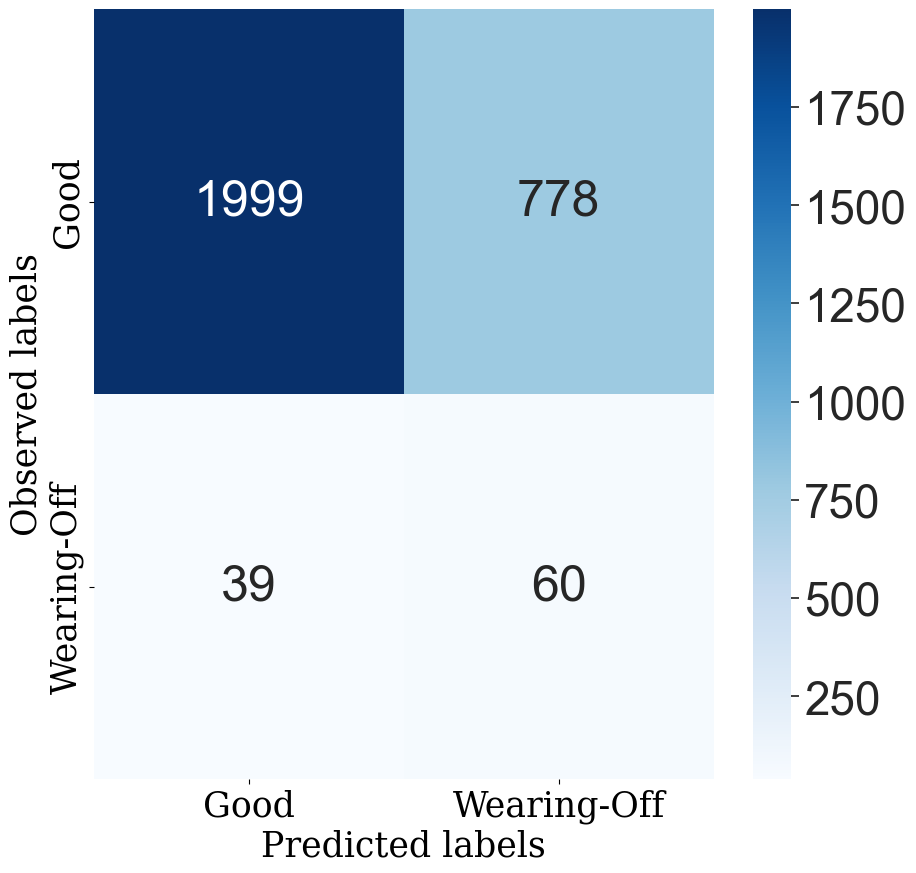

In [17]:
from photonai.base import Hyperpipe, PipelineElement
from photonai.optimization import FloatRange, Categorical
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])

final_pipeline1 = Hyperpipe('5 - Final Pipeline CI + FS + GB',
    outer_cv=StratifiedKFold(n_splits=5, shuffle=False),
    inner_cv=StratifiedKFold(n_splits=3, shuffle=False),
    use_test_set=True,
    metrics=list(metrics.keys()),
    best_config_metric='balanced_accuracy',
    optimizer='sk_opt',
    optimizer_params={'n_configurations': 30},
    project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
    cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
    verbosity=1
)


final_pipeline1 += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={'method_name': tested_methods})

# from sklearn.feature_selection import f_classif

# final_pipeline1 += PipelineElement('SelectKBest',
#                                    hyperparameters={'k': [5, 10, 'all']},
#                                    score_func=f_classif)



final_pipeline1 += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

# Fit hyperpipe
final_pipeline1.fit(X, y)

# Optionally print mean validation results
# print(final_pipeline1.results_handler.get_mean_of_best_validation_configs_per_estimator())

# Optionally print feature importances
# print_feature_importances(final_pipeline1)

# Optionally debug CV splits
# for k, v in final_pipeline1.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write additional reports
add_other_report_to_summary(final_pipeline1, with_estimator_comparison=False)

# Plot confusion matrix
plot_confusion_matrix_from_pipeline(final_pipeline1)


In [18]:
# Alternative 1: Built-in Feature Importances (Fastest)
print("Method 1: Built-in GradientBoosting Feature Importances")
print("-" * 55)
try:
    # Get the trained estimator
    gb_estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    
    if hasattr(gb_estimator, 'feature_importances_'):
        importances = gb_estimator.feature_importances_
        feature_names = np.array(columns[1:-1])
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        for i, idx in enumerate(indices):
            print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")
    else:
        print("Built-in feature importances not available")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")


Method 1: Built-in GradientBoosting Feature Importances
-------------------------------------------------------
time_from_last_drug_taken 0.8102
light                0.0914
heart_rate           0.0579
awake                0.0204
nonrem_total         0.0055
total                0.0042
deep                 0.0041
sleep_efficiency     0.0032
nonrem_percentage    0.0027
stress_score         0.0003
rem                  0.0000
steps                0.0000




In [19]:
# Alternative 2: Using sklearn's permutation_importance directly
print("Method 2: Sklearn Permutation Importance")
print("-" * 40)
try:
    from sklearn.inspection import permutation_importance
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a subset of data for faster computation (optional)
    # X_sample = X.sample(n=min(1000, len(X)), random_state=42)
    # y_sample = y.loc[X_sample.index]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        fitted_pipeline, X, y, 
        n_repeats=10,  # Reduced for speed
        random_state=42,
        scoring='balanced_accuracy'
    )
    
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {perm_importance.importances_mean[idx]:.4f} "
              f"±{perm_importance.importances_std[idx]:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 2: Sklearn Permutation Importance
----------------------------------------
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [20]:
# Alternative 3: SHAP Values (if you have shap installed)
print("Method 3: SHAP Feature Importance")
print("-" * 35)
try:
    import shap
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a sample for SHAP (it can be slow on large datasets)
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    
    # Create explainer
    explainer = shap.Explainer(fitted_pipeline, X_sample)
    shap_values = explainer(X_sample)
    
    # Get mean absolute SHAP values as feature importance
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(feature_importance)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {feature_importance[idx]:.4f}")
        
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 3: SHAP Feature Importance
-----------------------------------
Error: The passed model is not callable and cannot be analyzed directly with the given masker! Model: PhotonPipeline(elements=[('ImbalancedDataTransformer',
                          PipelineElement(config=None,
                                          method_name='RandomOverSampler',
                                          name='ImbalancedDataTransformer')),
                         ('GradientBoostingClassifier',
                          PipelineElement(ccp_alpha=0.0,
                                          criterion='friedman_mse', init=None,
                                          learning_rate=0.006817654224626131,
                                          loss='exponential', max_depth=3,
                                          max_features=None,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                           

In [21]:
# Alternative 4: Simple DataFrame approach for better visualization
print("Method 4: DataFrame Summary")
print("-" * 25)
try:
    import pandas as pd
    
    # Using the original hyperpipe method but organizing results better
    r = final_pipeline1.get_permutation_feature_importances(
        n_repeats=20,  # Reduced for speed
        random_state=0, 
        scoring='balanced_accuracy'
    )
    
    # Create DataFrame for better organization
    importance_df = pd.DataFrame({
        'Feature': np.array(columns[1:-1]),
        'Importance': r["mean"],
        'Std_Dev': r["std"],
        'Lower_Bound': r["mean"] - 2 * r["std"],
        'Upper_Bound': r["mean"] + 2 * r["std"]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 10
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Show only statistically significant features
    significant_features = importance_df[importance_df['Lower_Bound'] > 0]
    
    if len(significant_features) > 0:
        print(f"\nStatistically Significant Features ({len(significant_features)}):")
        print(significant_features.to_string(index=False, float_format='%.4f'))
    else:
        print("\nNo statistically significant features found")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 4: DataFrame Summary
-------------------------

Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [22]:
# Alternative 5: Quick and Simple (Minimal Code)
print("Method 5: Quick and Simple")
print("-" * 25)
try:
    # Just get the built-in importances with minimal code
    estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    importances = estimator.feature_importances_
    features = np.array(columns[1:-1])
    
    # Create sorted list of (importance, feature) tuples
    sorted_features = sorted(zip(importances, features), reverse=True)
    
    print("Feature Importance Ranking:")
    for i, (importance, feature) in enumerate(sorted_features[:15], 1):
        print(f"{i:2d}. {feature:<20} {importance:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

Method 5: Quick and Simple
-------------------------
Feature Importance Ranking:
 1. time_from_last_drug_taken 0.8751
 2. light                0.0489
 3. rem                  0.0464
 4. heart_rate           0.0211
 5. deep                 0.0055
 6. sleep_efficiency     0.0023
 7. stress_score         0.0007
 8. total                0.0000
 9. steps                0.0000
10. nonrem_total         0.0000
11. nonrem_percentage    0.0000
12. awake                0.0000
